# Create artifact from time series dataframe

In [1]:
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch

In [2]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Notebook config

In [3]:
base_path = Path.home()

In [4]:
import utils.config as cfg
config = cfg.get_artifact_config_sd2a(True)

yml: ./config/base.yaml
Getting content./config/base.yaml
... About to replace includes with content
Load content./config/base.yaml
-----------Project configuration-----------
user: mi-santamaria
project: deepvats
version: latest
data: Occupancy_estimation:latest
-----------Project configuration-----------
Current: /home/macu/work/nbs_pipeline
yml: ./config/base.yaml
yml: ./config/base.yaml
Getting content./config/base.yaml
... About to replace includes with content
Load content./config/base.yaml


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

In [5]:
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(config.data_fpath)
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')
    
print(f'File loaded successfully')
print(df.shape)
df.head()

File loaded successfully
(10129, 18)


,Timestamp,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [6]:
# Set the time columm (if any) as an index
if config.time_col is not None:
    print("time_col: "+str(config.time_col))
    if isinstance(config.time_col, int): 
        print("Op 1")
        datetime = df.iloc[:, config.time_col]
    elif isinstance(config.time_col, list): 
        print("Op 2")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    index = pd.DatetimeIndex(datetime)
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    print("... drop Timestamp col " + col_name)
    df = df.drop(col_name, axis=1)
df.head()

time_col: 0
Op 1
... drop Timestamp col Timestamp


,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
Timestamp,,,,,,,,,,,,,,,,,
2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [8]:
duplicated_rows = df.duplicated()
if (duplicated_rows.any()):
    print("There are duplicated rows")
    df = df.drop_duplicates()
    duplicated_rows = df.duplicated()
    if (duplicated_rows.any()):
        print("There are still duplicated rows")
    else:
        print("Now ok! There is no duplicated row")
else:
    print("There is no duplicated row")


There are duplicated rows
Now ok! There is no duplicated row


In [9]:
duplicated_indices = df.index.duplicated()
if duplicated_indices.any():
    print("Hay índices duplicados")
else:
    print("No hay índices duplicados")

No hay índices duplicados


In [10]:
# Set dataframe frequency
df = infer_or_inject_freq(df, injected_freq=config.freq, 
                          start_date=config.start_date, format=config.date_format)
df.index.freq

In [11]:
# Subset of variables
if config.data_cols:
    df = df.iloc[:, config.data_cols]

print(f'Num. variables: {len(df.columns)}')

Num. variables: 17


In [12]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

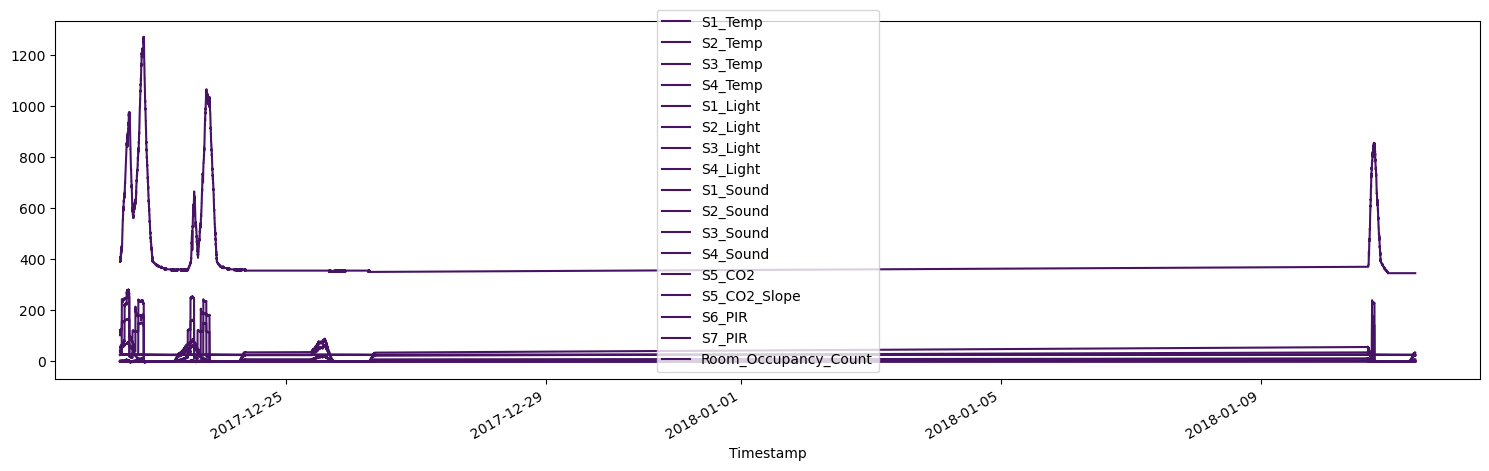

In [13]:
# Show time series plot
fig, ax = plt.subplots(1, figsize=(15,5), )
cmap = matplotlib.colormaps.get_cmap('viridis')
df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
# rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
# ax.add_patch(rect)
plt.tight_layout()
plt.legend()
plt.show()

### Data Transformation

__Handle Missing Values, Resample and Normalize__

In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied. This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

In [14]:
# Training data
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df
training_artifact = TSArtifact.from_df(df_training, 
                                       name=config.artifact_name, 
                                       missing_values_technique=config.missing_values_technique,
                                       resampling_freq=config.resampling_freq, 
                                       normalize=config.normalize_training, 
                                       path=str(Path.home()/config.wandb_artifacts_path))
display(training_artifact.metadata)

{'TS': {'sd': '2017-12-22 10:49:41',
  'ed': '2018-01-11 09:00:09',
  'created': 'from-df',
  'n_vars': 17,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 8828,
  'freq': 'None',
  'vars': ['S1_Temp',
   'S2_Temp',
   'S3_Temp',
   'S4_Temp',
   'S1_Light',
   'S2_Light',
   'S3_Light',
   'S4_Light',
   'S1_Sound',
   'S2_Sound',
   'S3_Sound',
   'S4_Sound',
   'S5_CO2',
   'S5_CO2_Slope',
   'S6_PIR',
   'S7_PIR',
   'Room_Occupancy_Count'],
  'hash': '-227886170659325340'}}

In [15]:
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
else:
    print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


In [16]:
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(df_train_test,
                                           name=config.artifact_name, 
                                           missing_values_technique=config.missing_values_technique,
                                           resampling_freq=config.resampling_freq, 
                                           normalize=False,
                                           path=str(Path.home()/config.wandb_artifacts_path))
    display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two.

In [17]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 01_dataset_artifact


In [18]:
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only
